# Data Source:
IBM Transactions for Anti Money Laundering (AML)
https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml


to run this code make sure all of the imports are installed

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from imblearn.over_sampling import BorderlineSMOTE
# Import the required libraries
from pyspark.sql import SparkSession
from pyspark import SparkConf

In [16]:

conf = SparkConf()

# Set the driver and executor memory
conf.set("spark.driver.memory", "4g")  # Set the driver memory to 4GB
conf.set("spark.executor.memory", "4g")  # Set the executor memory to 4GB

# Create a SparkSession with the configured SparkConf
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# Load the CSV file into a Spark DataFrame
data = spark.read.csv("HI-Small_Trans.csv", header=True, inferSchema=True)

In [17]:
data.head()

Row(Timestamp='2022/09/01 00:20', From Bank=10, Account2='8000EBD30', To Bank=10, Account4='8000EBD30', Amount Received=3697.34, Receiving Currency='US Dollar', Amount Paid=3697.34, Payment Currency='US Dollar', Payment Format='Reinvestment', Is Laundering=0)

## Why this dataset:
Logistic regression is well-suited for this dataset as it aligns with the binary classification task of identifying money laundering transactions (1) or non-money laundering transactions (0). The dataset's combination of categorical and numeric features, such as "Payment Format," "Receiving Currency," "Amount Received," and "Amount Paid," is efficiently handled by logistic regression without requiring extensive preprocessing. This model provides interpretable coefficients, aiding in the understanding of variables influencing money laundering probabilities. It's computationally efficient, making it suitable for datasets of varying sizes. Additionally, logistic regression outputs probabilities, allowing you to set custom thresholds for classification. The model can be regularized to enhance generalization and prevent overfitting, crucial for real-world data. In summary, logistic regression is a fitting choice for building a predictive model to detect potential money laundering transactions.

In [18]:
#data.info()
data.printSchema()
row_count = data.count()
print("Number of rows:", row_count)



root
 |-- Timestamp: string (nullable = true)
 |-- From Bank: integer (nullable = true)
 |-- Account2: string (nullable = true)
 |-- To Bank: integer (nullable = true)
 |-- Account4: string (nullable = true)
 |-- Amount Received: double (nullable = true)
 |-- Receiving Currency: string (nullable = true)
 |-- Amount Paid: double (nullable = true)
 |-- Payment Currency: string (nullable = true)
 |-- Payment Format: string (nullable = true)
 |-- Is Laundering: integer (nullable = true)

Number of rows: 5078345


In [19]:

# Group by the 'Is Laundering' column and count occurrences
value_counts = data.groupBy('Is Laundering').count()

# Show the result
value_counts.show()


+-------------+-------+
|Is Laundering|  count|
+-------------+-------+
|            1|   5177|
|            0|5073168|
+-------------+-------+



In [20]:

# Drop rows with missing values
data = data.dropna()


In [21]:
#data.info()
#data.info()
data.printSchema()
row_count = data.count()
print("Number of rows:", row_count)
#data.describe().show()


root
 |-- Timestamp: string (nullable = true)
 |-- From Bank: integer (nullable = true)
 |-- Account2: string (nullable = true)
 |-- To Bank: integer (nullable = true)
 |-- Account4: string (nullable = true)
 |-- Amount Received: double (nullable = true)
 |-- Receiving Currency: string (nullable = true)
 |-- Amount Paid: double (nullable = true)
 |-- Payment Currency: string (nullable = true)
 |-- Payment Format: string (nullable = true)
 |-- Is Laundering: integer (nullable = true)

Number of rows: 5078345


In [22]:

# Group by the 'Is Laundering' column and count occurrences
value_counts = data.groupBy('Is Laundering').count()

# Show the result
value_counts.show()


+-------------+-------+
|Is Laundering|  count|
+-------------+-------+
|            1|   5177|
|            0|5073168|
+-------------+-------+



The decision to convert the dataset back to a Pandas DataFrame was made for practicality and ease of use. While Apache Spark is a powerful framework for distributed data processing, it can have a steeper learning curve and requires managing data within a Spark-specific context. By transitioning the dataset back to Pandas, I can take advantage of its simplicity and flexibility. This choice facilitates a more streamlined and intuitive data exploration and analysis process.

In [23]:
# transform data to pandas data
data = data.toPandas()


In [24]:
# Convert categorical variables into numeric representations using LabelEncoder
label_encoders = {}
categorical_columns = ["From Bank", "Account2", "To Bank", "Account4", "Receiving Currency", "Payment Currency", "Payment Format"]

for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Split the data into train and test sets
X = data.drop(columns=['Is Laundering', 'Timestamp'])  # Drop the target variable and Timestamp
y = data['Is Laundering']



In [25]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Addressing the imbalance using BorderlineSMOTE
smote = BorderlineSMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Initialize and train the logistic regression model
clf = LogisticRegression(max_iter=1000)  
clf.fit(X_resampled, y_resampled)

# Check accuracy on test set
accuracy = clf.score(X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")



Accuracy: 78.18%


In [26]:
# Predictions
y_pred = clf.predict(X_test)

# Check metrics
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       1.00      0.78      0.88   1521902
           1       0.00      0.40      0.00      1602

    accuracy                           0.78   1523504
   macro avg       0.50      0.59      0.44   1523504
weighted avg       1.00      0.78      0.88   1523504



Text(0.5, 23.52222222222222, 'Predicted label')

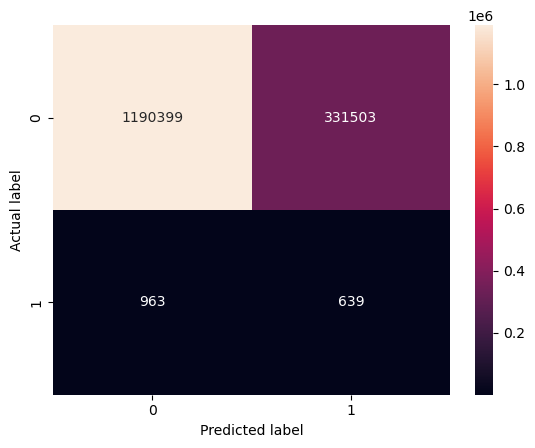

In [27]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')



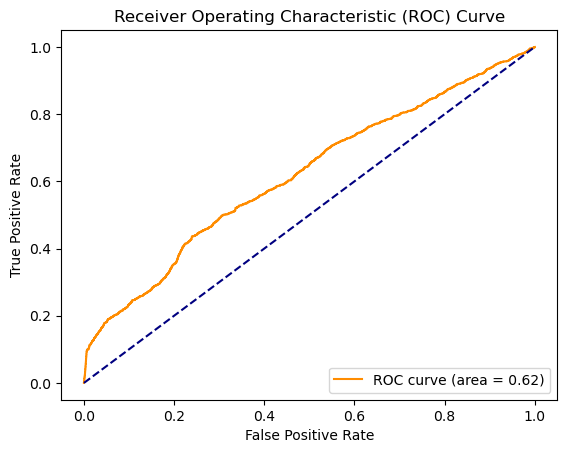

In [28]:
# ROC curve
y_prob = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()